In [11]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
import matplotlib.pyplot as plt
import matplotlib.style as style
from PIL import Image
import matplotlib.image as image
from matplotlib.patches import Rectangle

from highlight_text import fig_text, ax_text

style.use('fivethirtyeight')
import warnings
warnings.filterwarnings("ignore")

In [2]:
with open('models/rf_home.pkl', 'rb') as f:
    home_md = pickle.load(f)

with open('models/rf_away.pkl', 'rb') as f:
    away_md = pickle.load(f)


teams_data = pd.read_csv("data/new_model.csv")   

/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_stages
/Users/stephenahiabah/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._

In [3]:
def find_team_features(home, away):
    home_infos = teams_data[(teams_data.home_team == home) | (teams_data.away_team == home)].tail(1)
    if home_infos.home_team.values[0] == home:
        home_goals_scored = home_infos["home_goals_mean"].values[0]
        home_goals_suf = home_infos["home_goals_suf_mean"].values[0]
        home_points_made = home_infos["home_game_points_mean"].values[0]
        home_rank = home_infos["rank_home"].values[0]
    else:
        home_goals_scored = home_infos["away_goals_mean"].values[0]
        home_goals_suf = home_infos["away_goals_suf_mean"].values[0]
        home_points_made = home_infos["away_game_points_mean"].values[0]
        home_rank = home_infos["rank_away"].values[0]
        
    
    away_infos = teams_data[(teams_data.home_team == away) | (teams_data.away_team == away)].tail(1)
    if away_infos.home_team.values[0] == away:
        away_goals_scored = away_infos["home_goals_mean"].values[0]
        away_goals_suf = away_infos["home_goals_suf_mean"].values[0]
        away_points_made = away_infos["home_game_points_mean"].values[0]
        away_rank = away_infos["rank_home"].values[0]
    else:
        away_goals_scored = away_infos["away_goals_mean"].values[0]
        away_goals_suf = away_infos["away_goals_suf_mean"].values[0]
        away_points_made = away_infos["away_game_points_mean"].values[0]
        away_rank = away_infos["rank_away"].values[0]

    #print(home_rank, away_rank)
    rank_dif = home_rank - away_rank
    ht_features = [
        home_goals_scored*rank_dif,
        away_goals_suf*rank_dif,
        home_points_made*rank_dif,
        away_points_made*rank_dif
    ]
    
    at_features = [
        away_goals_scored*rank_dif,
        home_goals_suf*rank_dif,
        home_points_made*rank_dif,
        away_points_made*rank_dif
    ]
    return ht_features, at_features

In [77]:
home_team = "Belgium"

away_team = "Slovakia"

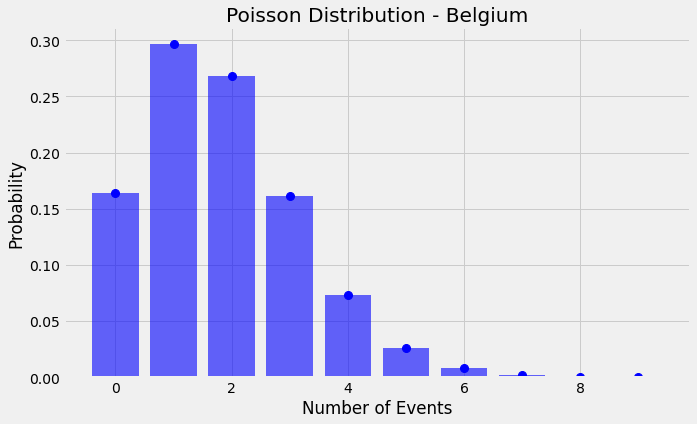

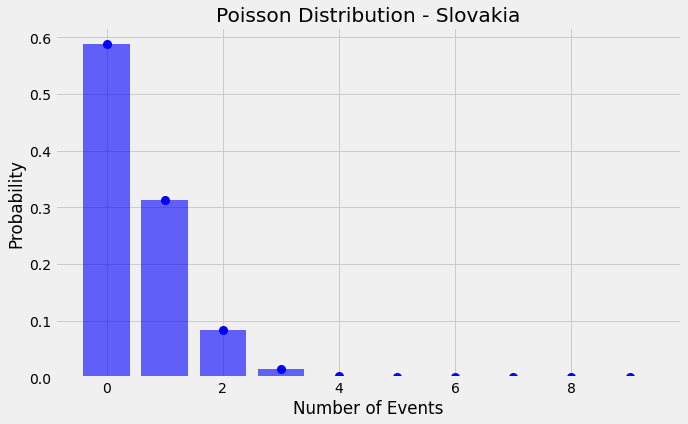

In [78]:
g, s = find_team_features(home_team, away_team)

xg_g = home_md.predict([g])[0]
xg_s = away_md.predict([s])[0]


poisson_probs_g = poisson.pmf(np.arange(0, 10), xg_g)
poisson_probs_s = poisson.pmf(np.arange(0, 10), xg_s)


def plot_poisson(x, poisson_probs, team):
    plt.figure(figsize=(10, 6))
    plt.bar(x, poisson_probs, alpha=0.6, color='blue')
    plt.plot(x, poisson_probs, 'bo', ms=8)
    plt.title(f'Poisson Distribution - {team}')
    plt.xlabel('Number of Events')
    plt.ylabel('Probability')
    plt.grid(True)
    plt.show()

plot_poisson(np.arange(0,10), poisson_probs_g, home_team)
plot_poisson(np.arange(0,10), poisson_probs_s, away_team)

res_track = np.zeros((10,10))

for i in range(len(poisson_probs_g)):
    for j in range(len(poisson_probs_s)):
        res_prob = poisson_probs_g[i]*poisson_probs_s[j]
        res_track[j][i] = res_prob

res_df = pd.DataFrame(res_track)

# res_df.columns = ["Italy " + str(a) for a in res_df.columns] 
# res_df.index = ["Albania " + str(a) for a in res_df.index] 


def find_probs(poisson_home, poisson_away):
    home_probs = []
    away_probs = []
    draw_probs = []
    both_score_probs = []
    over_1_5_probs = []
    under_1_5_probs = []
    over_2_5_probs = []
    under_2_5_probs = []
    
    for i in range(len(poisson_home)):
        for j in range(len(poisson_away)):
            res_prob = poisson_home[i] * poisson_away[j]
            
            if i == j:
                draw_probs.append(res_prob)
            elif i > j:
                home_probs.append(res_prob)
            elif j > i:
                away_probs.append(res_prob)
            
            # Both teams score
            if i > 0 and j > 0:
                both_score_probs.append(res_prob)
            
            # Over and under 1.5 goals
            if (i + j) > 1.5:
                over_1_5_probs.append(res_prob)
            else:
                under_1_5_probs.append(res_prob)
                
            # Over and under 2.5 goals
            if (i + j) > 2.5:
                over_2_5_probs.append(res_prob)
            else:
                under_2_5_probs.append(res_prob)
    
    both_score_prob = sum(both_score_probs)
    over_1_5_prob = sum(over_1_5_probs)
    under_1_5_prob = sum(under_1_5_probs)
    over_2_5_prob = sum(over_2_5_probs)
    under_2_5_prob = sum(under_2_5_probs)

    # max_prob_index = np.unravel_index(np.argmax(res_track), res_track.shape)
    # g1, g2 = max_prob_index

    
    return (sum(home_probs), sum(draw_probs), sum(away_probs), 
            poisson_home.tolist().index(max(poisson_home.tolist())), 
            poisson_away.tolist().index(max(poisson_away.tolist())),
            both_score_prob, over_1_5_prob, under_1_5_prob, 
            over_2_5_prob, under_2_5_prob)

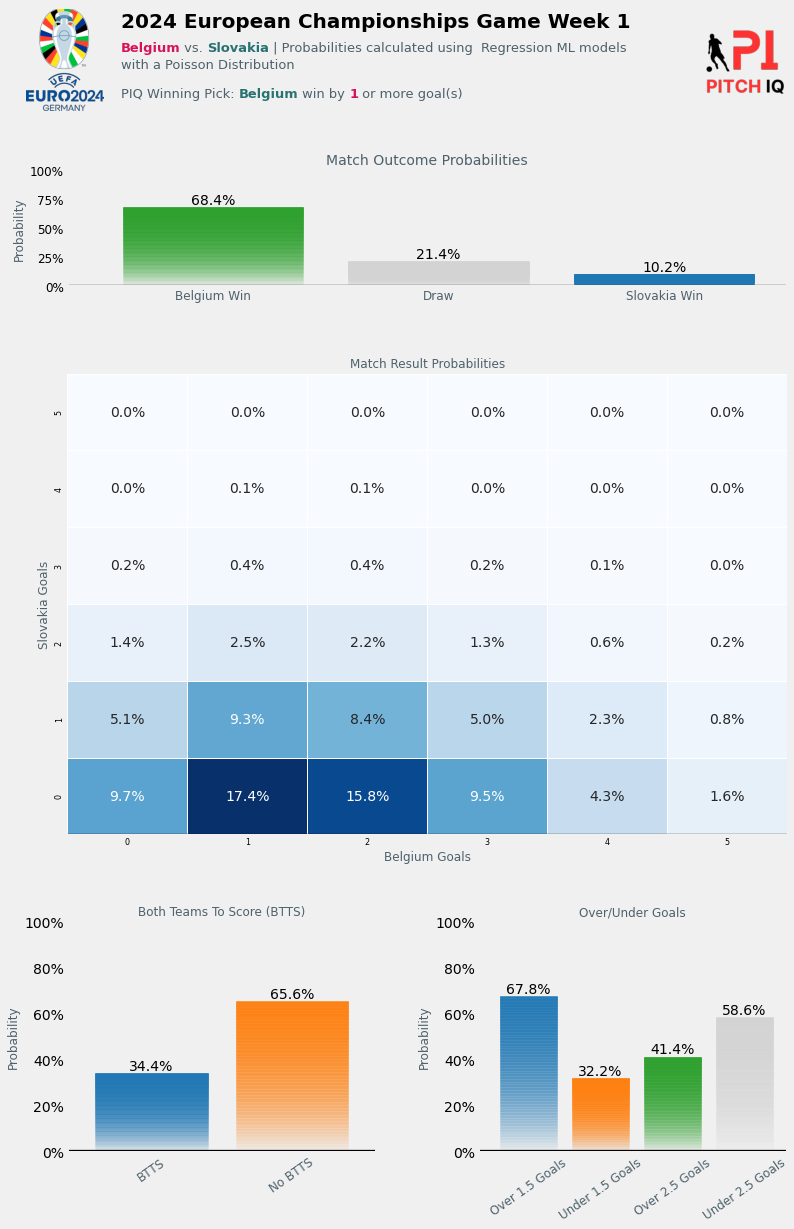

In [79]:
home_prob, draw_prob, away_prob, max_home, max_away, both_score_prob, over_1_5_prob, under_1_5_prob, over_2_5_prob, under_2_5_prob = find_probs(poisson_probs_g, poisson_probs_s)

# Custom function to create gradient bars
def gradient_bar(ax, x, y, width, height, color):
    N = 256
    for i in range(N):
        ax.add_patch(Rectangle(
            (x, y + height * i / N), width, height / N,
            color=color, alpha=(i / N)
        ))

# Plotting the results
fig = plt.figure(figsize=(12, 16))
gs = fig.add_gridspec(3, 2, height_ratios=[1, 4, 2])

# Bar plot for match outcome probabilities
ax1 = fig.add_subplot(gs[0, :])
bars1 = ['Home Win', 'Draw', 'Away Win']
values1 = [home_prob, draw_prob, away_prob]
colors1 = ['#2ca02c', '#d3d3d3', '#1f77b4']
for i, (bar, value, color) in enumerate(zip(bars1, values1, colors1)):
    gradient_bar(ax1, i - 0.4, 0, 0.8, value, color)
    ax1.text(i, value, f'{value:.1%}', ha='center', va='bottom')

ax1.set_ylim(0, 1)
ax1.set_ylabel('Probability', fontsize=12, color='#4E616C', font='Karla')
ax1.set_title('Match Outcome Probabilities', size=14, color='#4E616C', font='Karla')
ax1.set_xticks(range(len(bars1)))
ax1.set_xticklabels([f'{home_team} Win', 'Draw', f'{away_team} Win'], fontsize=10, color='#4E616C', font='Karla')
ax1.tick_params(axis='both', which='major', labelsize=12, color='#4E616C')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
ax1.axhline(y=0.01, color='black', linewidth=1.3)
ax1.axvline(x=-0.5, color='black', linewidth=0.001)
ax1.axvline(x=2.5, color='black', linewidth=0.001)

# Heatmap for match result probabilities
res_df = res_df.iloc[:6, :6]
ax2 = fig.add_subplot(gs[1, :])
sns.heatmap(res_df, annot=True, fmt=".1%", cmap="Blues", cbar=False, linewidths=.5, ax=ax2)
ax2.set_title('Match Result Probabilities', size=12, color='#4E616C', font='Karla')
ax2.invert_yaxis()
ax2.tick_params(axis='both', which='major', labelsize=8, color='#4E616C')
ax2.set_xlabel(f'{home_team} Goals', fontsize=12, color='#4E616C', font='Karla')
ax2.set_ylabel(f'{away_team} Goals', fontsize=12, color='#4E616C', font='Karla')
ax2.axhline(y=0.01, color='black', linewidth=1.3)
ax2.axvline(x=0, color='black', linewidth=0.001)

# Bar plot for additional stats - BTTS
additional_stats_1 = {
    'Both Teams Score': both_score_prob,
    'Both Teams Not to Score': 1 - both_score_prob,
}
ax3 = fig.add_subplot(gs[2, 0])
bars3 = list(additional_stats_1.keys())
values3 = list(additional_stats_1.values())
colors3 = ['#1f77b4', '#ff7f0e']
for i, (bar, value, color) in enumerate(zip(bars3, values3, colors3)):
    gradient_bar(ax3, i - 0.4, 0, 0.8, value, color)
    ax3.text(i, value, f'{value:.1%}', ha='center', va='bottom')

ax3.set_ylim(0, 1)
ax3.set_ylabel('Probability', fontsize=12, color='#4E616C')
ax3.set_title('Both Teams To Score (BTTS)', size=12, color='#4E616C', font='Karla')
ax3.set_xticks(range(len(bars3)))
ax3.set_xticklabels(['BTTS', 'No BTTS'], size=12, rotation=35, color='#4E616C')
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
ax3.axhline(y=0.01, color='black', linewidth=1.3)
ax3.axvline(x=-0.5, color='black', linewidth=0.001)
ax3.axvline(x=1.5, color='black', linewidth=0.001)

# Bar plot for additional stats - Over/Under
additional_stats_2 = {
    'Over 1.5 Goals': over_1_5_prob,
    'Under 1.5 Goals': under_1_5_prob,
    'Over 2.5 Goals': over_2_5_prob,
    'Under 2.5 Goals': under_2_5_prob
}
ax4 = fig.add_subplot(gs[2, 1])
bars4 = list(additional_stats_2.keys())
values4 = list(additional_stats_2.values())
colors4 = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d3d3d3']
for i, (bar, value, color) in enumerate(zip(bars4, values4, colors4)):
    gradient_bar(ax4, i - 0.4, 0, 0.8, value, color)
    ax4.text(i, value, f'{value:.1%}', ha='center', va='bottom')

ax4.set_ylim(0, 1)
ax4.set_ylabel('Probability', fontsize=12, color='#4E616C')
ax4.set_title('Over/Under Goals', size=12, color='#4E616C', font='Karla')
ax4.set_xticks(range(len(bars4)))
ax4.set_xticklabels(['Over 1.5 Goals', 'Under 1.5 Goals', 'Over 2.5 Goals', 'Under 2.5 Goals'], size=12, rotation=35, color='#4E616C', font='Karla')
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
ax4.axhline(y=0.01, color='black', linewidth=1.3)
ax4.axvline(x=-0.5, color='black', linewidth=0.001)
ax4.axvline(x=3.5, color='black', linewidth=0.001)

# Remove grid lines
for ax in [ax1, ax2, ax3, ax4]:
    ax.grid(False)


fig_text(
    x=0.18, y=1.07, 
    s='2024 European Championships Game Week 1',
    va='bottom', ha='left',
    fontsize=20, color='black', font='DM Sans', weight='bold'
)
fig_text(
	x=0.18, y=1.035, 
    s=f'<{home_team}> vs. <{away_team}> | Probabilities calculated using  Regression ML models \nwith a Poisson Distribution',
    highlight_textprops=[{'weight':'bold', 'color': '#D81159'}, {'weight':'bold', 'color': '#287271'}],
	va='bottom', ha='left',
	fontsize=13, color='#4E616C', font='Karla'
)
if max_home > max_away  : 
        fig_text(
        x=0.18, y=1.01, 
        s=f"PIQ Winning Pick: <{home_team}> win by <{max_home - max_away}> or more goal(s)",
        highlight_textprops=[{'weight':'bold', 'color': '#287271'}, {'weight':'bold', 'color': '#D81159'}],
        va='bottom', ha='left',
        fontsize=13, color='#4E616C', font='Karla'
    )
elif max_away > max_home: 
        fig_text(
        x=0.18, y=1.01, 
        s=f"PIQ Winning Pick: <{away_team}> win by <{max_away - max_home}> or more goal(s)",
        highlight_textprops=[{'weight':'bold', 'color': '#287271'}, {'weight':'bold', 'color': '#D81159'}],
        va='bottom', ha='left',
        fontsize=13, color='#4E616C', font='Karla'
    )
else: 
        fig_text(
        x=0.18, y=1.01, 
        s=f"PIQ Winning Pick: <Match Draw>",
        highlight_textprops=[{'weight':'bold', 'color': '#D81159'}],
        va='bottom', ha='left',
        fontsize=13, color='#4E616C', font='Karla'
    )

ax5 = fig.add_axes([0.07, 0.17, 0.09, 1.75])
ax5.axis('off')
img = image.imread('/Users/stephenahiabah/Desktop/GitHub/Webs-scarping-for-Fooball-Data-/Images/UEFA_Euro_2024_Logo.svg.png')
ax5.imshow(img)


### Add Stats by Steve logo
ax6 = fig.add_axes([0.85, 0.17, 0.1, 1.75])
ax6.axis('off')
img = image.imread('/Users/stephenahiabah/Desktop/GitHub/Webs-scarping-for-Fooball-Data-/outputs/piqmain.png')
ax6.imshow(img)

plt.tight_layout(pad=3.0)
plt.show()
